In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from matplotlib import pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams["axes.edgecolor"] = "black"

## EDA notebook

In [2]:
df_classes = pd.read_csv("data/elliptic_txs_classes.csv")
df_edges = pd.read_csv("data/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("data/elliptic_txs_features.csv")

In [3]:
df_classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txId    203769 non-null  int64 
 1   class   203769 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [4]:
df_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234355 entries, 0 to 234354
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   txId1   234355 non-null  int64
 1   txId2   234355 non-null  int64
dtypes: int64(2)
memory usage: 3.6 MB


In [5]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 167 entries, txId to aggregate_feature_72
dtypes: float64(165), int64(2)
memory usage: 259.6 MB


### Merge the classes into the features frame

In [6]:
# This merged df will be used for analysis and training
df_class_feature = pd.merge(df_classes, df_features)
df_class_feature.head()

,txId,class,time_step,local_feature_1,local_feature_2,local_feature_3,local_feature_4,local_feature_5,local_feature_6,local_feature_7,...,aggregate_feature_63,aggregate_feature_64,aggregate_feature_65,aggregate_feature_66,aggregate_feature_67,aggregate_feature_68,aggregate_feature_69,aggregate_feature_70,aggregate_feature_71,aggregate_feature_72
0,230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,licit,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,unknown,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


### Classes 

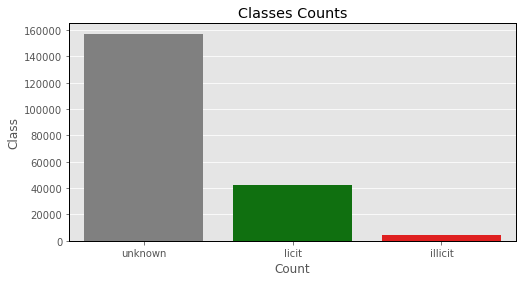

In [8]:
# Just get a rough idea of the # classes
sns.barplot(x = df_class_feature['class'].value_counts().index
           ,y = df_class_feature['class'].value_counts().values
           ,palette = ['gray','green','r'])
plt.title('Classes Counts')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

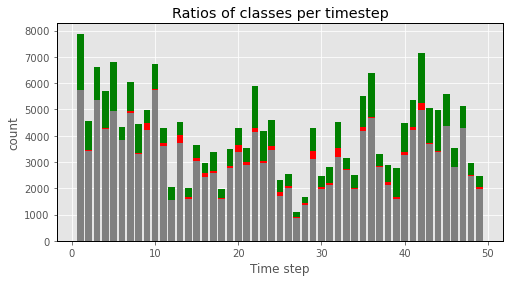

In [9]:
# Kek
group_class_feature = df_class_feature.groupby(['time_step', 'class']).count()['txId'].reset_index().rename(columns={'txId': 'count'})

# Classes per time step
# Don't try to make sense of variable names
# Just copy/pasted whatever to make plot work.
class1 = group_class_feature[group_class_feature['class'] == 'licit']
class2 = group_class_feature[group_class_feature['class'] == 'illicit']
class3 = group_class_feature[group_class_feature['class'] == 'unknown' ]

p1 = plt.bar(class3['time_step'], class3['count'], color = 'gray')

p2 = plt.bar(class2['time_step'], class2['count'], color='r',
             bottom = class3['count'])

p3 = plt.bar(class1['time_step'], class1['count'], color='g',
             bottom = np.array(class3['count']) + np.array(class2['count']))

plt.xlabel('Time step')
plt.ylabel('count')
plt.title('Ratios of classes per timestep')

plt.show()

## Graph view

In [10]:
def plot_graph(nodes,edges,time_step):
    """
    Plots randomly scattered graphviz 
    at a specific time step
    
    nodes = dataframe
    edges = dataframe
    time_step = int
    
    """
    graphs_list = []
    pos_list = []
    
    for cat in ('illicit','licit'):
        ids = nodes.loc[(nodes['time_step'] == time_step) & (nodes['class'] == cat), 'txId']
        edge = edges.loc[edges['txId1'].isin(ids)]
        graphs = nx.from_pandas_edgelist(edge,
                                         source = 'txId1',
                                         target = 'txId2', 
                                         create_using = nx.DiGraph())   
        pos = nx.random_layout(graphs)
        
        graphs_list.append(graphs)
        pos_list.append(pos)
        
    colors = ('red','green')
    alphas = (0.9,0.2)
    sizes = (100,300)
        
    for i in range(2):
        nx.draw(graphs_list[i],
                with_labels = False,
                pos = pos_list[i],
                style = '--',
                node_color = colors[i],
                alpha = alphas[i],
                node_size = sizes[i])
    plt.title(f'Random Graph view at t = {time_step}')
    plt.show()


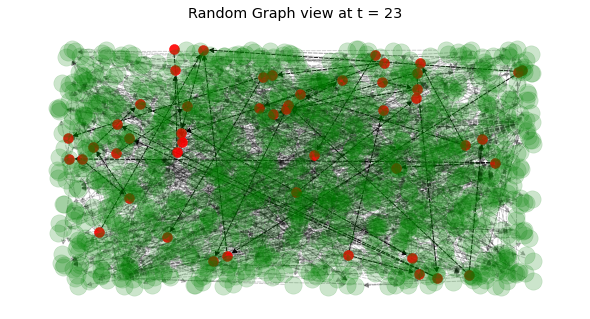

In [11]:
plot_graph(df_class_feature,df_edges,23)

## Temporal check

In [112]:
df_edges.shape

(234355, 2)

In [118]:
df_edges.iloc[:,0].nunique()

166345

In [119]:
df_edges.iloc[:,1].nunique()

148447

In [120]:
df_class_feature.shape

(203769, 168)

In [161]:
df_class_feature['txId'].nunique()

203769

There are no edges between the timestamps, but there are repeating nodes sending and receiving. So there is a temporal aspect to take into account. 